# Example of preproc2

Calculate a linear trend of `piControl` over a period corresponding to both the
150 years of `abrupt-4xCO2` and the 140 years of `1pctCO2`. Subtract this linear
trend from the original output, and save the results as anomaly data over the
limited period. The length of the period may exceed 150 years, depending on the
branch years of `abrupt-4xCO2` and `1pctCO2`. The years of `abrupt-4xCO2` and `1pctCO2`
are adjusted so that their time coordinates are the same as in `piControl`.

Use `mce/script/preproc2.py` for a stand-alone script.

In [1]:
import yaml
import numpy as np
import pandas as pd
import iris
from scipy.stats import linregress
from mce.script.preproc1 import CmipData
from mce import get_logger
from mce.util.plot import wrap_plotspace

In [2]:
logger = get_logger('mce')

In [3]:
with open('../mce/data/dataset.yml', 'r') as infile:
    cfg = yaml.safe_load(infile)

In [4]:
cmip = CmipData('none', 'none', 'none')
cfg_variables = cmip.cfg_variables
project, dataset = 'CMIP6', 'IPSL-CM6A-LR'
cfg1 = cfg[project]['source'][dataset]

map_length = {
    'abrupt-4xCO2': 150,
    'abrupt4xCO2': 150,
    '1pctCO2': 140,
    '1pctCO2-4xext': 70,
}

data_in = []
data_in_index = []
data_out = []
data_out_index = []

In [5]:
for varname in ['rtnt', 'tas']:
    cubes = {}
    y_start = {}
    y_end = {}

    for expname in cfg1:
        path = './{}_{}_{}.nc'.format(varname, dataset, expname)
        logger.info('Reading {}'.format(path))
        cubes[expname] = iris.load_cube(path)

        if expname == 'piControl':
            continue

        y_start[expname] = cfg1[expname]['branch_year']
        y_end[expname] = y_start[expname] + map_length[expname] -1

    y_period = (min(y_start.values()), max(y_end.values()))

    coord_pi = cubes['piControl'].coord('year')
    slc_period = slice(
        np.where(coord_pi.points==y_period[0])[0][0],
        np.where(coord_pi.points==y_period[1])[0][0] + 1)
    pi_reg = linregress(
        coord_pi.points[slc_period], cubes['piControl'].data[slc_period])

    attrs = {
        'model': dataset,
        'linear_trend_slope': pi_reg.slope,
        'linear_trend_interception': pi_reg.intercept}

    for expname, cube in cubes.items():
        if expname == 'piControl':
            slc_coord = slc_period
            slc_data = slc_period
        else:
            i0 = np.where(coord_pi.points==y_start[expname])[0][0]
            length = map_length[expname]
            slc_coord = slice(i0, i0+length)
            if dataset == 'HadGEM2-ES':
                # skip the initial time point that has December only
                slc_data = slice(1, 1+length)
            else:
                slc_data = slice(0, length)

        trend = pi_reg.slope * coord_pi.points[slc_coord] + pi_reg.intercept

        cube_anom = iris.cube.Cube(
            cube.data[slc_data] - trend,
            attributes=attrs,
            aux_coords_and_dims=[(coord_pi[slc_coord], 0)],
            **cfg_variables[varname])

        outpath = './{}_{}_{}_anom.nc'.format(varname, dataset, expname)
        logger.info('Writing {}'.format(outpath))
        iris.save(cube_anom, outpath)
        
        data_in.append(
            pd.Series(cube.data[slc_data], coord_pi[slc_coord].points))
        data_in_index.append((varname, expname))
        if expname == 'piControl':
            data_in.append(pd.Series(trend, coord_pi[slc_coord].points))
            data_in_index.append((varname, 'trend'))
        data_out.append(
            pd.Series(cube_anom.data, cube_anom.coord('year').points))
        data_out_index.append((varname, expname))

[2020-03-29 16:41:22 mce] INFO:Reading ./rtnt_IPSL-CM6A-LR_piControl.nc
[2020-03-29 16:41:22 mce] INFO:Reading ./rtnt_IPSL-CM6A-LR_abrupt-4xCO2.nc
[2020-03-29 16:41:22 mce] INFO:Reading ./rtnt_IPSL-CM6A-LR_1pctCO2.nc
[2020-03-29 16:41:22 mce] INFO:Writing ./rtnt_IPSL-CM6A-LR_piControl_anom.nc
[2020-03-29 16:41:22 mce] INFO:Writing ./rtnt_IPSL-CM6A-LR_abrupt-4xCO2_anom.nc
[2020-03-29 16:41:22 mce] INFO:Writing ./rtnt_IPSL-CM6A-LR_1pctCO2_anom.nc
[2020-03-29 16:41:22 mce] INFO:Reading ./tas_IPSL-CM6A-LR_piControl.nc
[2020-03-29 16:41:22 mce] INFO:Reading ./tas_IPSL-CM6A-LR_abrupt-4xCO2.nc
[2020-03-29 16:41:22 mce] INFO:Reading ./tas_IPSL-CM6A-LR_1pctCO2.nc
[2020-03-29 16:41:22 mce] INFO:Writing ./tas_IPSL-CM6A-LR_piControl_anom.nc
[2020-03-29 16:41:22 mce] INFO:Writing ./tas_IPSL-CM6A-LR_abrupt-4xCO2_anom.nc
[2020-03-29 16:41:22 mce] INFO:Writing ./tas_IPSL-CM6A-LR_1pctCO2_anom.nc


In [6]:
data_in = pd.DataFrame(
    data_in, index=pd.MultiIndex.from_tuples(data_in_index))
data_out = pd.DataFrame(
    data_out, index=pd.MultiIndex.from_tuples(data_out_index))

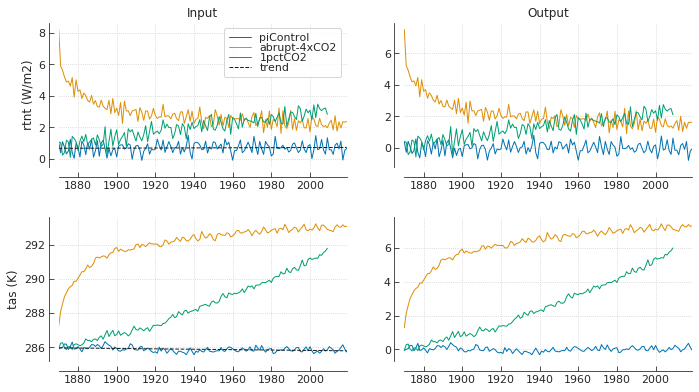

In [7]:
kw_space = {'aspect': 2., 'height': 2}
p1 = wrap_plotspace(4, 2, kw_space=kw_space)

exps = ['piControl', 'abrupt-4xCO2', '1pctCO2']
map_units = {'rtnt': 'W/m2', 'tas': 'K'}

for i, varname in enumerate(['rtnt', 'tas']):
    ax = p1.figure.axes[2*i]
    p1.despine(ax, offset=10)
    data_in.loc[varname].T[exps+['trend']].plot(ax=ax, legend=False)
    ax.lines[-1].set_color('k')
    ax.lines[-1].set_linestyle('--')
    if i == 0:
        ax.legend(labelspacing=0.)
    ax.set_ylabel('{} ({})'.format(varname, map_units[varname]))
    if i % 2 == 0:
        ax.set_title('Input')
    ax.grid()

    ax = p1.figure.axes[2*i+1]
    p1.despine(ax, offset=10)
    data_out.loc[varname].T[exps].plot(ax=ax, legend=False)
    if i % 2 == 0:
        ax.set_title('Output')
    ax.grid()